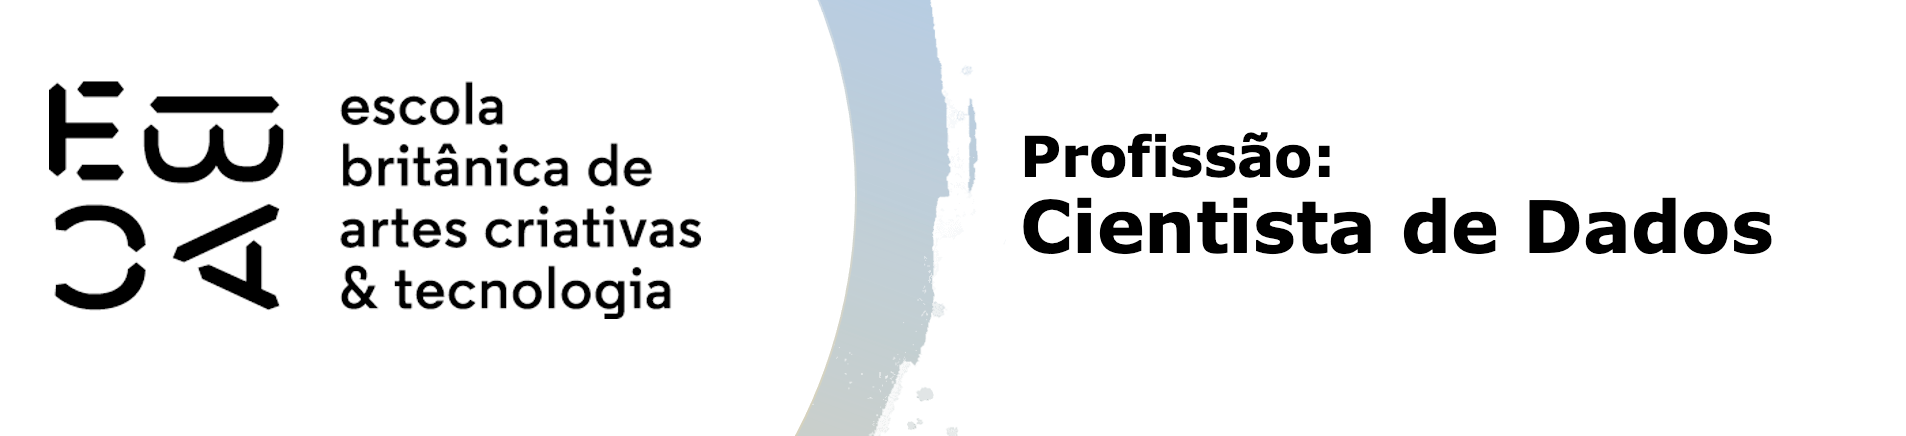

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

from gower import gower_matrix

%reload_ext watermark
%watermark -iv -v -p gower,scipy,sklearn

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

gower  : 0.1.2
scipy  : 1.11.4
sklearn: 1.3.2

seaborn   : 0.13.0
pandas    : 2.1.3
matplotlib: 3.8.2
numpy     : 1.26.2



In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [5]:
Analise = pd.DataFrame(df.dtypes, columns=['Dtypes']).assign(Missing = df.isna().sum(),
                                                             Valores_Unicos = df.nunique())

Analise

,Dtypes,Missing,Valores_Unicos
Administrative,int64,0,27
Administrative_Duration,float64,0,3335
Informational,int64,0,17
Informational_Duration,float64,0,1258
ProductRelated,int64,0,311
ProductRelated_Duration,float64,0,9551
BounceRates,float64,0,1872
ExitRates,float64,0,4777
PageValues,float64,0,2704
SpecialDay,float64,0,6


In [6]:
Month_sorted = ['Feb', 'Mar', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df['Month'] = df['Month'].apply(lambda x: (Month_sorted.index(x)))

df['Month'].value_counts()

Month
2    3364
8    2998
1    1907
9    1727
7     549
6     448
5     433
4     432
3     288
0     184
Name: count, dtype: int64

In [7]:
def plot_count(ax, x):
    
    ax = sns.countplot(ax=ax,
                       x= x,
                       data= df)
    
    ax.set_ylabel('Contagem', fontsize=17, labelpad=20)
    ax.set_xlabel(None      , fontsize=17, labelpad=20)
    ax.set_title(x, size=20)
    ax.tick_params(labelsize= 13)
    
    sizes = []
    
    for p in ax.patches:
        height = p.get_height()
        sizes.append(height)
        ax.annotate(text= height.astype('int'),
                    xy  = (p.get_x()+0.4, height+100),
                    ha  = 'center',
                    size= 18)
    
    ax.set_ylim(0,max(sizes)*1.1)
    return ax

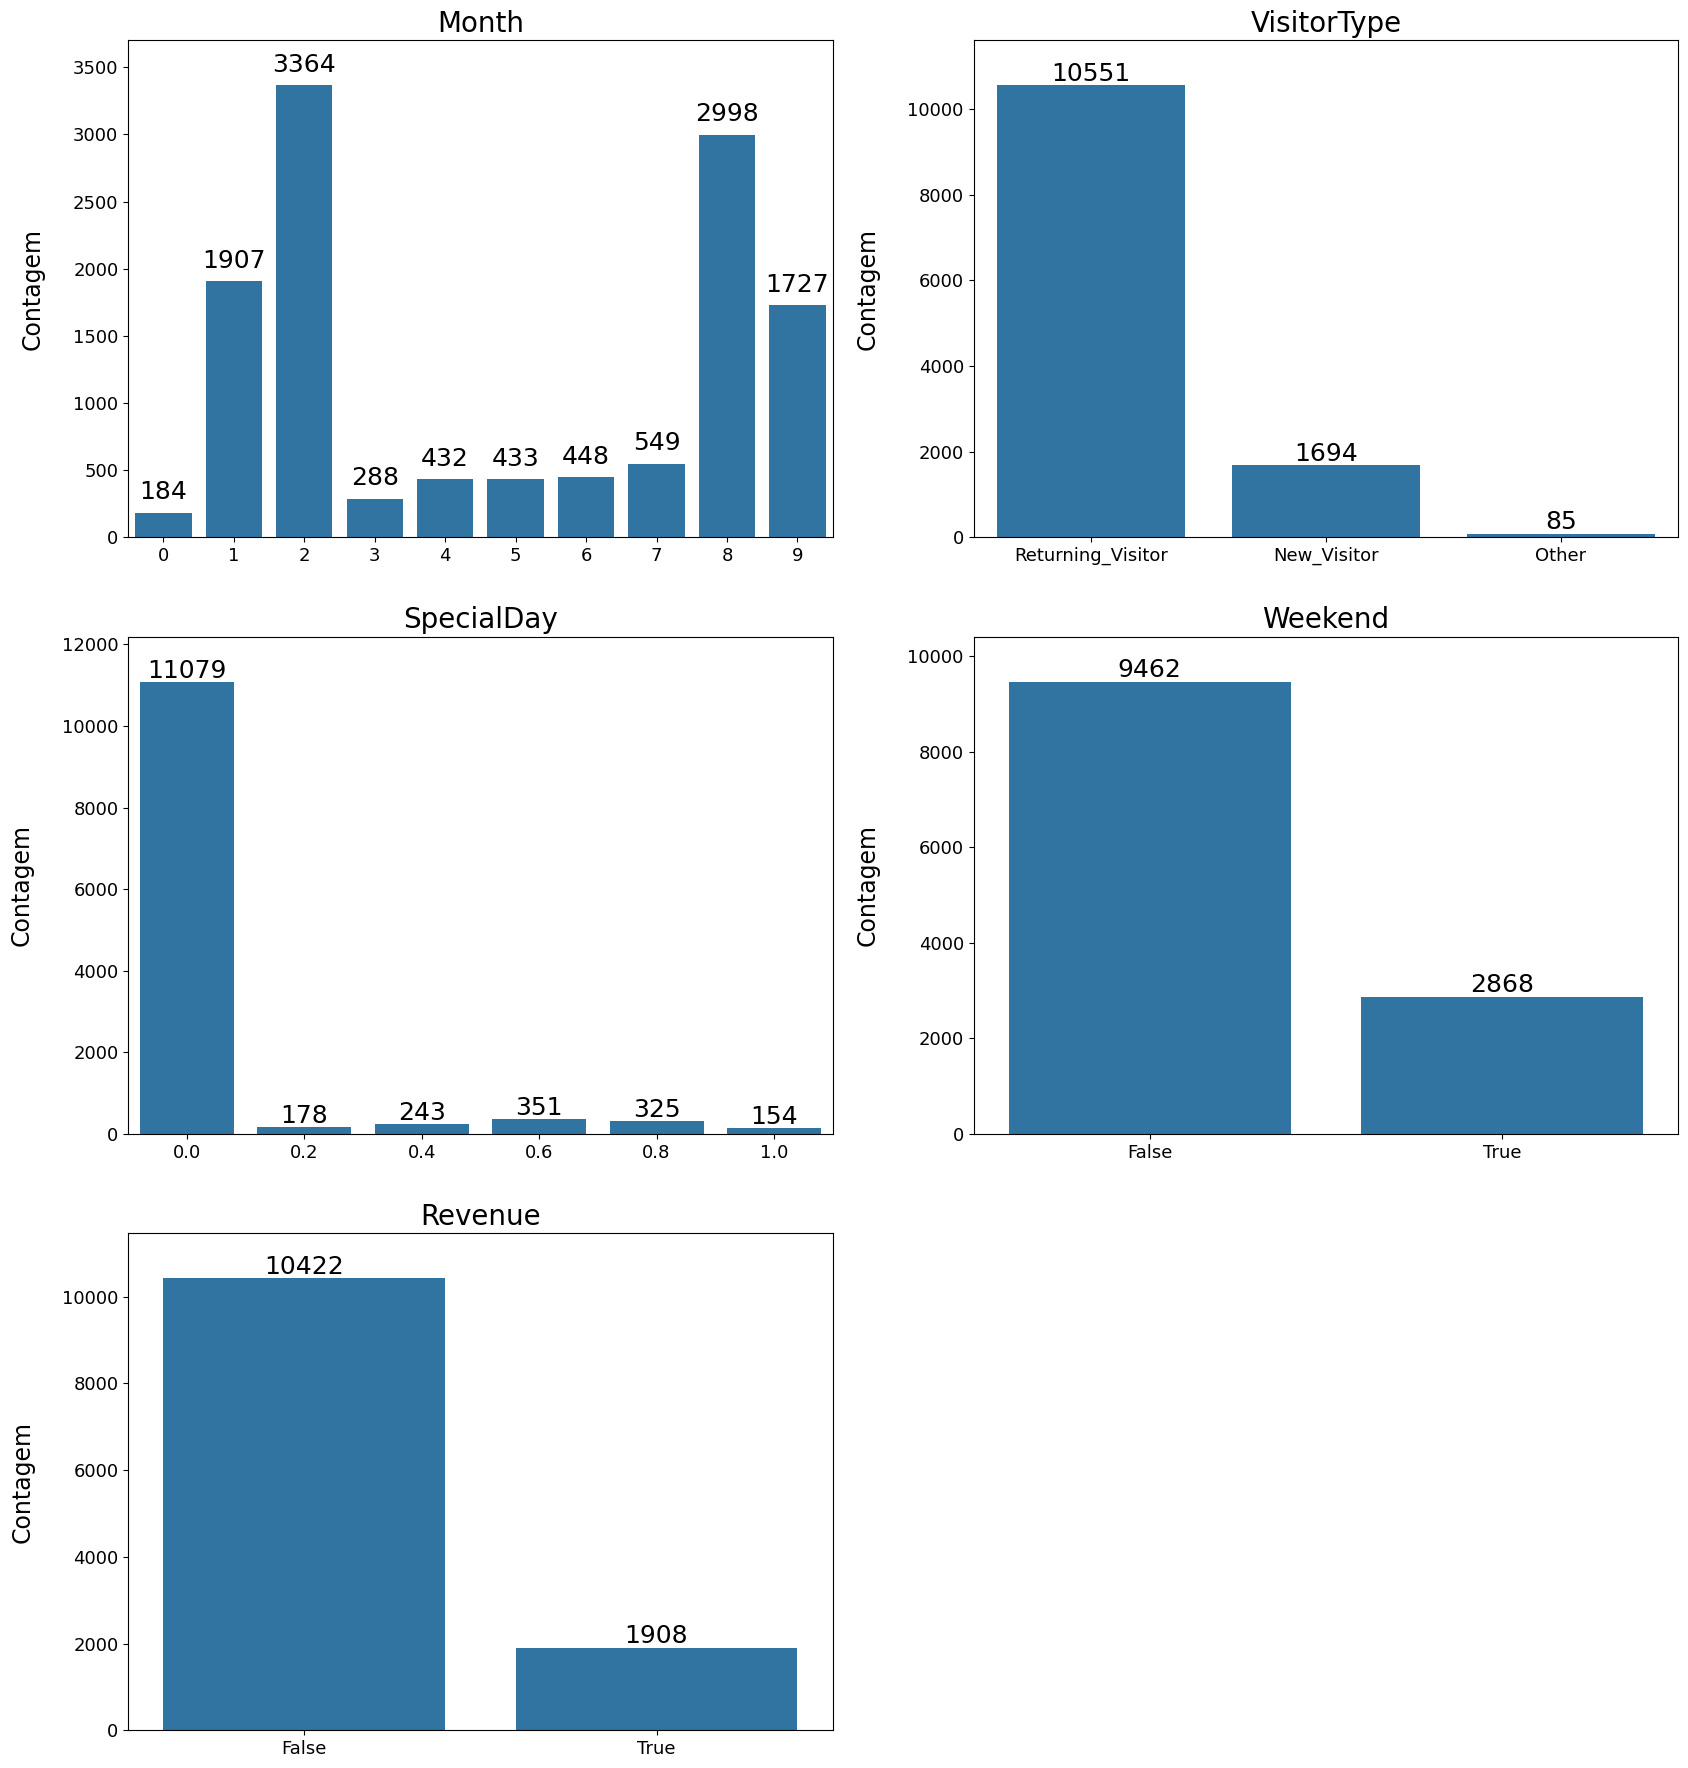

In [8]:
plt.close('all')

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))

plt.subplots_adjust(top=1.8)

ax1 = plot_count(ax=axes[0,0], x='Month')
ax2 = plot_count(ax=axes[0,1], x='VisitorType')
ax3 = plot_count(ax=axes[1,0], x='SpecialDay')
ax4 = plot_count(ax=axes[1,1], x='Weekend')
ax5 = plot_count(ax=axes[2,0], x='Revenue')
ax=axes[2,1].remove()

In [9]:
variaveis = ['Administrative',
             'Administrative_Duration',
             'Informational',
             'Informational_Duration',
             'ProductRelated',
             'ProductRelated_Duration',
             'SpecialDay',
             'Month',
             'Weekend',
             'VisitorType',
             'Revenue']

In [10]:
df_dummy = pd.get_dummies(data=df[variaveis], columns=['VisitorType'])

df_dummy.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay,Month,Weekend,Revenue,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.0,0,False,False,False,False,True
1,0,0.0,0,0.0,2,64.000000,0.0,0,False,False,False,False,True
2,0,0.0,0,0.0,1,0.000000,0.0,0,False,False,False,False,True
3,0,0.0,0,0.0,2,2.666667,0.0,0,False,False,False,False,True
4,0,0.0,0,0.0,10,627.500000,0.0,0,True,False,False,False,True


In [11]:
df_dummy['Weekend'] = df_dummy['Weekend'].astype(int)
df_dummy['Revenue'] = df_dummy['Revenue'].astype(int)
df_dummy['VisitorType_New_Visitor'] = df_dummy['VisitorType_New_Visitor'].astype(int)
df_dummy['VisitorType_Other'] = df_dummy['VisitorType_Other'].astype(int)
df_dummy['VisitorType_Returning_Visitor'] = df_dummy['VisitorType_Returning_Visitor'].astype(int)

df_dummy.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay,Month,Weekend,Revenue,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.0,0,1,0,0,0,1


In [12]:
df_pad = pd.DataFrame(StandardScaler().fit_transform(df_dummy.select_dtypes('number')), columns=df_dummy.select_dtypes('number').columns)

df_pad

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay,Month,Weekend,Revenue,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,-0.308821,-1.521403,-0.550552,-0.427872,-0.399087,-0.083316,0.410621
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.308821,-1.521403,-0.550552,-0.427872,-0.399087,-0.083316,0.410621
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,-0.308821,-1.521403,-0.550552,-0.427872,-0.399087,-0.083316,0.410621
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,-0.308821,-1.521403,-0.550552,-0.427872,-0.399087,-0.083316,0.410621
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.308821,-1.521403,1.816360,-0.427872,-0.399087,-0.083316,0.410621
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.206173,0.363075,-0.396478,-0.244931,0.478227,0.307822,-0.308821,1.318464,1.816360,-0.427872,-0.399087,-0.083316,0.410621
12326,-0.696993,-0.457191,-0.396478,-0.244931,-0.601062,-0.380957,-0.308821,1.002923,1.816360,-0.427872,-0.399087,-0.083316,0.410621
12327,-0.696993,-0.457191,-0.396478,-0.244931,-0.578577,-0.528063,-0.308821,1.002923,1.816360,-0.427872,-0.399087,-0.083316,0.410621
12328,0.507228,-0.032916,-0.396478,-0.244931,-0.376210,-0.443536,-0.308821,1.002923,-0.550552,-0.427872,-0.399087,-0.083316,0.410621


## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [13]:
vars_cat = [True if x in ['Month',
                          'Weekend',
                          'VisitorType_New_Visitor',
                          'VisitorType_Returning_Visitor',
                          'Revenue'] else False for x in df_pad.columns]
vars_cat

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True]

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [14]:
distancia_gower = gower_matrix(df_pad, cat_features=vars_cat)

In [15]:
distancia_gower[:5,:5]

array([[0.0000000e+00, 1.8606566e-04, 0.0000000e+00, 1.1231720e-04,
        7.8659594e-02],
       [1.8606566e-04, 0.0000000e+00, 1.8606566e-04, 7.3748459e-05,
        7.8473523e-02],
       [0.0000000e+00, 1.8606566e-04, 0.0000000e+00, 1.1231720e-04,
        7.8659594e-02],
       [1.1231720e-04, 7.3748459e-05, 1.1231720e-04, 0.0000000e+00,
        7.8547277e-02],
       [7.8659594e-02, 7.8473523e-02, 7.8659594e-02, 7.8547277e-02,
        0.0000000e+00]], dtype=float32)

In [16]:
gdv = squareform(distancia_gower, force='tovector')
gdv.shape

(76008285,)

In [17]:
Z = linkage(gdv, method='complete')
Z_df = pd.DataFrame(Z, columns=['id1', 'id2', 'dist', 'n'])
Z_df.head()

,id1,id2,dist,n
0,0.0,2.0,0.0,2.0
1,16.0,12330.0,0.0,3.0
2,6.0,79.0,0.0,2.0
3,24.0,50.0,0.0,2.0
4,91.0,12333.0,0.0,3.0


Leaves = 11292


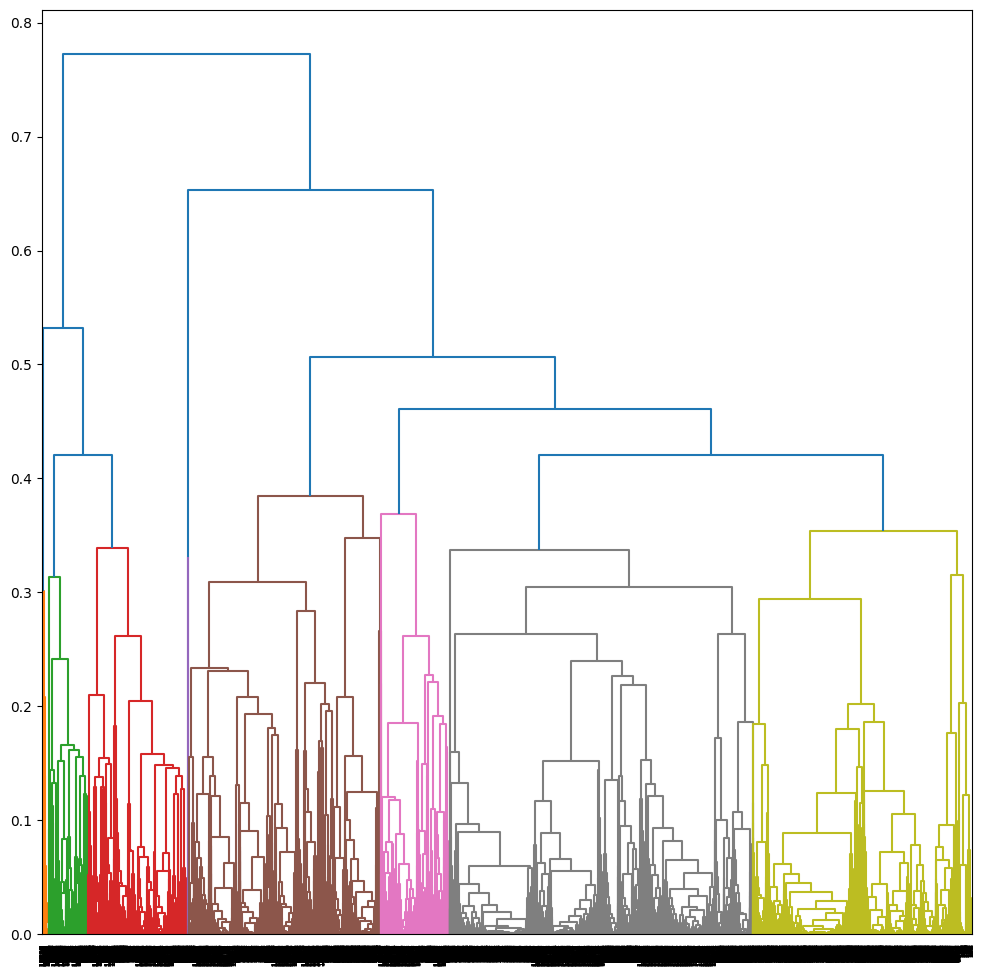

In [74]:
fig,axs = plt.subplots(1,1,figsize=(12,12))
dn = dendrogram(Z, truncate_mode='level',p=30,show_leaf_counts=True,ax=axs, color_threshold=.42)
print(f"Leaves = {len(dn['leaves'])}")

In [47]:
df_pad['grupo_3'] = fcluster(Z, 3, criterion='maxclust')
df_pad['grupo_4'] = fcluster(Z, 4, criterion='maxclust')
df_pad['grupo_5'] = fcluster(Z, 5, criterion='maxclust')
df_pad['grupo_6'] = fcluster(Z, 6, criterion='maxclust')

print(f'{df_pad.grupo_3.value_counts()}\n--------------------------')
print(f'{df_pad.grupo_4.value_counts()}\n--------------------------')
print(f'{df_pad.grupo_5.value_counts()}\n--------------------------')
print(f'{df_pad.grupo_6.value_counts()}\n--------------------------')

grupo_3
3    10548
1     1779
2        3
Name: count, dtype: int64
--------------------------
grupo_4
4    10548
2     1694
1       85
3        3
Name: count, dtype: int64
--------------------------
grupo_5
5    8168
4    2380
2    1694
1      85
3       3
Name: count, dtype: int64
--------------------------
grupo_6
6    7337
4    2380
2    1694
5     831
1      85
3       3
Name: count, dtype: int64
--------------------------


## 3 Grupos:

In [48]:
# GRUPO 1 = 'Other' e 'New_Visitor' de 'VisitorType'
# GRUPO 2 = None
# GRUPO 3 = 'Returning_Visitor' de 'VisitorType'
df_3grupos = df.reset_index().merge(df_pad['grupo_3'].reset_index(), how='left')
df_3grupos['grupo_3'] = df_3grupos['grupo_3'].map({1: '1_Other_New_Visitor', 2: None, 3: '2_Returning_Visitor'})
df_3grupos.groupby(['VisitorType', 'Weekend', 'grupo_3'])['index'].count().unstack().fillna(0).style.highlight_quantile(color='orange').highlight_max(color='green', axis = 1).format(precision=0)

## 4 Grupos:

In [49]:
# GRUPO 1 = 'Other' de 'VisitorType'
# GRUPO 2 = 'New_Visitor' de 'VisitorType'
# GRUPO 3 = None
# GRUPO 4 = 'Returning_Visitor' de 'VisitorType'
df_4grupos = df.reset_index().merge(df_pad['grupo_4'].reset_index(), how='left')
df_4grupos['grupo_4'] = df_4grupos['grupo_4'].map({1: '1_Other', 2: '2_New_Visitor', 3: None, 4: '4_Returning_Visitor'})
df_4grupos.groupby(['VisitorType', 'Weekend', 'grupo_4'])['index'].count().unstack().fillna(0).style.highlight_quantile(color='orange').highlight_max(color='green', axis = 1).format(precision=0)

## 5 Grupos:

In [50]:
# GRUPO 1 = 'Other' de 'VisitorType'
# GRUPO 2 = 'New_Visitor' de 'VisitorType'
# GRUPO 3 = None
# GRUPO 4 = 'Returning_Visitor' de 'VisitorType' + True de 'Weekend'
# GRUPO 5 = 'Returning_Visitor' de 'VisitorType' + False de 'Weekend'
df_5grupos = df.reset_index().merge(df_pad['grupo_5'].reset_index(), how='left')
df_5grupos['grupo_5'] = df_5grupos['grupo_5'].map({1: '1_Other', 2: '2_New_Visitor', 3: None, 4: '4_Returning_Weekend', 5: '5_Returning_NotWeekend'})
df_5grupos.groupby(['VisitorType', 'Weekend', 'grupo_5'])['index'].count().unstack().fillna(0).style.highlight_quantile(color='orange').highlight_max(color='green', axis = 1).format(precision=0)

## 6 Grupos:

In [71]:
# GRUPO 1 = 'Other' de 'VisitorType'
# GRUPO 2 = 'New_Visitor' de 'VisitorType'
# GRUPO 3 = None
# GRUPO 4 = 'Returning_Visitor' de 'VisitorType' + True de 'Weekend'
# GRUPO 5 = 'Returning_Visitor' de 'VisitorType' + False de 'Weekend' + True de 'Revenue'
# GRUPO 6 = 'Returning_Visitor' de 'VisitorType' + False de 'Weekend' + False de 'Revenue'
df_6grupos = df.reset_index().merge(df_pad['grupo_6'].reset_index(), how='left')
df_6grupos['grupo_6'] = df_6grupos['grupo_6'].map({1:'1_Other', 2: '2_New_Visitor', 3: None, 4: '4_Returning_Weekend', 5: '5_Returning_NotWeekend_RevTrue', 6: '6_Returning_NotWeekend_RevFalse'})
df_6grupos.groupby(['VisitorType', 'Weekend', 'Revenue', 'grupo_6'])['index'].count().unstack().fillna(0).style.highlight_quantile(color='orange').highlight_max(color='green', axis = 1).format(precision=0)

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?